# Time Series Classification and Clustering Assignment

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

### Import the Walmart stock price data set (WMT_data.csv).

In [2]:
url = 'https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%205/WMT_data.csv'
df = pd.read_csv(url)
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,71.20,71.64,71.070,71.48,5906823,WMT
1,2013-02-11,71.25,71.51,70.530,71.40,6202534,WMT
2,2013-02-12,71.49,71.66,71.100,71.40,4761910,WMT
3,2013-02-13,71.29,71.70,71.210,71.39,3969807,WMT
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT


In [3]:
df['date'] = pd.to_datetime(df.date)
df.columns = ['Date', 'Open', 'High', 'Low', 'Observed', 'Volume', 'Ticker']
df = df[['Date', 'Observed']]
data = df.copy()
data.head()

,Date,Observed
0,2013-02-08,71.48
1,2013-02-11,71.40
2,2013-02-12,71.40
3,2013-02-13,71.39
4,2013-02-14,70.82


### Transform the data to be able to predict minor direction changes in the stock's price, given 180 days of history.

- Remember to calculate daily returns from the observed values (closing price).
- Make the critera for identifying a direction change when the observed values (closing price) cross the 5 day moving average.
- Create a binary column that defaults to 0 unless the criteria is met (then updates to 1).
- Shift the data set so that you have 180 days of history for each record.

In [4]:
data['returns'] = data.Observed.pct_change()
data['MA_5'] = data.Observed.rolling(5).mean()
data['MA_10'] = data.Observed.rolling(10).mean()

data['Trend'] = 'None'
data.loc[(data.MA_5 < data.MA_10), 'Trend'] = 'Negative'
data.loc[(data.MA_5 < data.MA_10), 'Trend'] = 'Positive'
data['Change'] = data.Trend.eq(data.Trend.shift())

data['Binary'] = 0
data.loc[(data.Change ==False) & (data.Trend != 'None'), 'Binary'] = 1
data.dropna(inplace=True)
data.drop(data.index[0], inplace=True)


In [8]:
transformed = data[['Date', 'returns', 'Binary']].copy()
history = 180
future = 0

shifts = [x + future for x in list(range(1, history+1))]

for shift in shifts:
  transformed['t-'+str(shift)] = transformed['returns'].shift(shift)

transformed.dropna(inplace=True)

### Train a Logistic Regression classification model on the transformed data.

In [13]:
X = transformed.drop(['Date', 'returns', 'Binary'], axis=1)
y = transformed['Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
predictions = model.predict(X_test)

### Run a classification report and evaluate the performance of the classifier.

In [14]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       200
           1       0.09      0.21      0.13        14

    accuracy                           0.81       214
   macro avg       0.52      0.53      0.51       214
weighted avg       0.88      0.81      0.84       214



### Transform the data again to have 10 days of history for clustering.

In [15]:
transformed = data[['Date', 'returns', 'Binary']].copy()
history = 10
future = 0

shifts = [x + future for x in list(range(1, history+1))]

for shift in shifts:
  transformed['t-'+str(shift)] = transformed['returns'].shift(shift)

transformed.dropna(inplace=True)
X = transformed.drop(['Date', 'returns', 'Binary'], axis=1)

### Train a K Means clustering model on the data. 

Try different values for K and see how the summary changes.

In [28]:
def kmeans(df, clusters=2):
  model = KMeans(n_clusters=clusters, random_state=42)
  clusters = model.fit_predict(df)
  results = df.copy()
  results['Cluster'] = clusters

  cluster_size = results.groupby(['Cluster']).size().reset_index()
  cluster_size.columns = ['Cluster', 'Count']
  cluster_means = results.groupby(['Cluster'], as_index=False).mean()
  summary = pd.merge(cluster_size, cluster_means, on='Cluster')
  return results, summary

results, summary = kmeans(X, clusters=8)

In [29]:
summary.style.background_gradient()

,Cluster,Count,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,0,172,0.001227,0.000655,-0.002915,0.001486,0.003900,0.000242,0.012042,-0.000342,-0.004006,0.001464
1,1,155,0.007339,-0.007981,-0.010035,0.000967,-0.000378,0.001291,-0.003357,0.003017,0.000495,0.000617
2,2,162,0.005957,0.007326,0.000676,-0.011278,-0.002042,0.002172,-0.000124,-0.001871,0.001020,0.000907
3,3,146,-0.001285,-0.004012,0.008599,0.000589,0.001395,0.002762,-0.002758,-0.007005,-0.006147,0.010160
4,4,189,-0.000166,0.001614,0.002135,0.002301,0.008456,-0.005049,-0.005888,0.000604,0.009823,0.002476
5,5,144,-0.001289,-0.002055,0.003984,0.001739,0.001186,0.010009,0.001442,-0.001542,0.003418,-0.010838
6,6,139,-0.009868,0.004487,0.000243,0.000032,-0.001052,0.000682,-0.000386,0.011500,-0.004726,-0.002012
7,7,132,-0.001094,0.002080,0.000773,0.008206,-0.012418,-0.008226,0.002483,-0.000603,0.001058,-0.000949


In [32]:
results, summary = kmeans(X, clusters=3)
summary.style.background_gradient()

,Cluster,Count,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,0,360,0.005306,-0.005094,-0.003055,0.000632,0.005654,-0.003205,-0.003687,0.000705,0.004508,-0.000323
1,1,436,0.000121,0.003537,0.003357,-0.004192,-0.001234,0.005063,-0.000527,-0.003982,0.000629,0.004977
2,2,443,-0.003544,0.001526,0.000130,0.004600,-0.002322,-0.001266,0.004637,0.004462,-0.003183,-0.003553


In [33]:
results, summary = kmeans(X, clusters=5)
summary.style.background_gradient()

,Cluster,Count,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,0,229,-0.008803,-0.001084,0.008882,0.000498,0.001045,0.001477,-0.001163,0.000309,-0.004029,0.004064
1,1,277,0.005035,0.000458,0.001568,0.006445,-0.004633,-0.004139,0.006887,-0.002578,-0.000528,0.000274
2,2,217,0.000722,0.003536,0.000008,-0.004671,-0.001951,0.005507,0.004025,0.008503,-0.002204,-0.007580
3,3,247,0.003077,-0.008422,-0.001434,0.000388,0.004846,-0.003418,-0.005966,0.002377,0.005658,-0.000522
4,4,269,0.000361,0.006759,-0.006299,-0.002022,0.002748,0.003533,-0.002023,-0.004813,0.002366,0.004636


### Visualize the summary of the clustering results as a heatmap.

In [46]:
h = summary.T.copy()
h.drop(['Cluster', 'Count'], inplace=True)
h

,0,1,2,3,4
t-1,-0.008803,0.005035,0.000722,0.003077,0.000361
t-2,-0.001084,0.000458,0.003536,-0.008422,0.006759
t-3,0.008882,0.001568,0.000008,-0.001434,-0.006299
t-4,0.000498,0.006445,-0.004671,0.000388,-0.002022
t-5,0.001045,-0.004633,-0.001951,0.004846,0.002748
t-6,0.001477,-0.004139,0.005507,-0.003418,0.003533
t-7,-0.001163,0.006887,0.004025,-0.005966,-0.002023
t-8,0.000309,-0.002578,0.008503,0.002377,-0.004813
t-9,-0.004029,-0.000528,-0.002204,0.005658,0.002366
t-10,0.004064,0.000274,-0.007580,-0.000522,0.004636


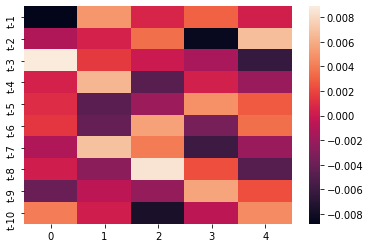

In [47]:
sns.heatmap(data=h)